In [1]:
import pandas as pd
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy.stats as scs
filename = "X_train/X_train.h5"

eggs = []
for i in range(1, 8):
    np_array = np.array(h5py.File(filename, mode='r')['eeg_'+str(i)])
    eggs.append(np_array)

In [3]:
filename='y_train.csv'

ytrain=np.array(pd.read_csv(filename))
for i in range(5):
    print('occurence sleep stage',i,np.count_nonzero(ytrain[:,1]== i))
y=ytrain[:,1]

occurence sleep stage 0 3511
occurence sleep stage 1 1671
occurence sleep stage 2 9449
occurence sleep stage 3 5224
occurence sleep stage 4 4833


In [2]:
def extractfbands(eeg,cuts):
    L=list()
    s=eeg.shape
    idcut=int(s[1]/cuts)
    freq=np.fft.fftfreq(idcut,1/50)[:int(idcut/2)]
    for i in range(cuts):
        print(i)
        FFT=np.fft.fft(eeg[:,i*idcut:(i+1)*idcut],axis=1)[:,:int(idcut/2)]
        FFT=abs(FFT)
        delta=np.sum(FFT[:,np.where((freq<4)*(freq>0))],axis=2)
        theta=np.sum(FFT[:,np.where((freq>4)* (freq<8))],axis=2)
        alpha=np.sum(FFT[:,np.where((freq>8)* (freq<13))],axis=2)
        beta=np.sum(FFT[:,np.where((freq>13 )* (freq<22))],axis=2)
        gamma=np.sum(FFT[:,np.where(freq>22)],axis=2)
        plt.plot(gamma/gamma.mean())
        plt.plot(alpha/alpha.mean())
        plt.plot(delta/delta.mean())
        L.append( np.array([delta,theta,alpha,beta,gamma]))
    return np.array(L)


def extractfmax(eeg,cuts):
    L=list()
    s=eeg.shape
    idcut=int(s[1]/cuts)
    freq=np.fft.fftfreq(idcut,1/50)[:int(idcut/2)]
    for i in range(cuts):
        print(i)
        FFT=np.fft.fft(eeg[:,i*idcut:(i+1)*idcut],axis=1)[:,:int(idcut/2)]
        FFT=abs(FFT)
        plt.plot(freq,(FFT*freq)[2000])
        f=np.sum(FFT*freq,axis=1)/np.sum(FFT,axis=1)
        plt.plot(freq,FFT[2000])
        print(f[2000],f.shape)
        L.append(f)
        plt.xlim(0,10)
    return np.array(L)

0
5.1732417165320586 (24688,)


array([[5.24328179, 1.49477656, 5.49781799, ..., 2.58627113, 8.03066829,
        5.89942706]])

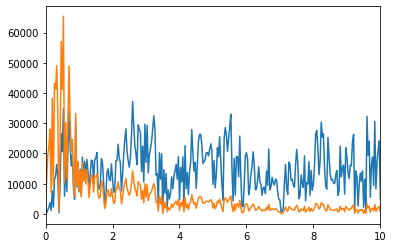

In [56]:
extractfmax(eggs[0],1)

0


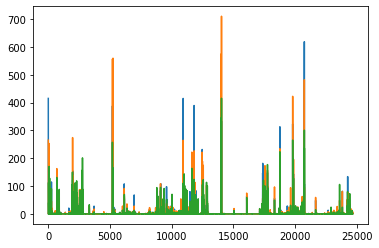

In [22]:
eeg1band=extractfbands(eggs[0],1)


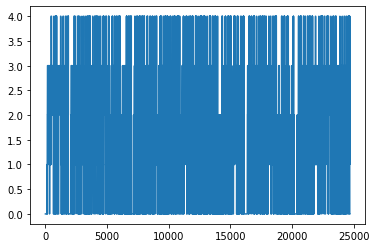

In [5]:
plt.plot(y)

0
0
0
0
0
0
0


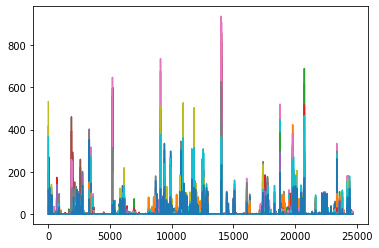

In [3]:
L=list()
for i in range(7):
    L.append(extractfbands(eggs[i],1))
L=np.array(L)

In [4]:
L.shape

(7, 1, 5, 24688, 1)

In [6]:
L[1,0,4,10,0]

117884.749450301

In [7]:
L2=np.reshape(L,(7,1,5,24688))
print(L2.shape)
rearranged_L = np.moveaxis(L2,[3],[0])
print(rearranged_L.shape)


(7, 1, 5, 24688)
(24688, 7, 1, 5)


In [8]:
L2[1,0,4,10]

117884.749450301

In [10]:
rearranged_L[10,1,0,4]

117884.749450301

In [12]:
final_L=np.reshape(rearranged_L,(24688,7,5))
final_L=np.reshape(final_L,(24688,7*5))

In [13]:
final_L[10,15+4]

19719.293566471704

In [ ]:
plt.plot(final_L[200])

In [14]:
np.save("fbands.npy", np.array(final_L))

In [1]:
def entropyarray(x,bins):
    L=list()
    for elt in x:
        L.append(entropySignal(elt,bins))
    return np.array(L)


def entropySignal(x,bins):
    hist=np.histogram(x,bins=bins,density=True)[0]
    return scs.entropy(hist)

In [6]:
entreegs=np.array([entropyarray(eggs[i],1000) for i in range(7)])

In [15]:
entreegs.std()

0.8017898641461614

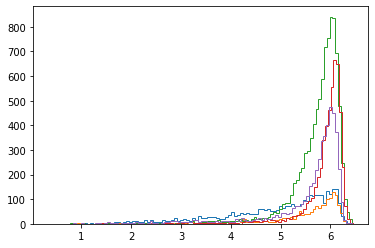

In [16]:
L=[np.where(ytrain==i) for i in range(5)]
for ide in L:
    plt.hist(entreegs.T[ide],bins=100,histtype='step',label='sleep stage'+str(i))

In [14]:
np.save('entreeg.npy',entreegs.T)

In [17]:
varray=np.array([np.log(np.var(eggs[i],axis=1)) for i in range(7)])

In [19]:
minmax=np.array([(np.max(eggs[i],axis=1)-np.min(eggs[i],axis=1)) for i in range(7)])    #dans open c normalisé eegnorm pas ici

In [30]:
minmaxvarray=np.array([minmax.T,varray.T])    
minmaxvarray= np.moveaxis(minmaxvarray,[1],[0])
minmaxvarray=minmaxvarray.reshape((24688,14))

In [31]:
minmaxvarray.shape

(24688, 14)

In [32]:
np.save('minmaxvarray.npy',minmaxvarray)

In [33]:
def d(epochs):
    '''epochs an array of time series cut in time the way you want
    output is a distance d
    '''
    dx=abs(np.argmax(epochs,axis=1)-np.argmin(epochs,axis=1)) 
    dy=np.max(epochs,axis=1)-np.min(epochs,axis=1)
    return np.sqrt(dx**2+dy**2)
    
def partitionsum(ts,lepoch=10,lts=30):
    '''ts : array of time series
    lepoch :duration of epoch
    lts = duration of time series
    '''
    if lts%lepoch!=0:
        print('lts must be a multiple of lepoch')
        
    indexts=ts.shape[1]    
    nepoch=int(lts/lepoch)
    indexepoch=int(indexts/nepoch)
    sum=0
    for i in range (nepoch):
        sum+=d(ts[:,i*indexepoch:(i+1)*indexepoch])
    return sum



In [36]:
MMD=np.array([np.log(partitionsum(eggs[i],3)) for i in range(7)])

In [38]:
np.save('MMD.npy',MMD.T)

0
4.69165146184943 (24688,)
1
4.580791133442307 (24688,)
0
4.697176399524804 (24688,)
1
4.548893757139955 (24688,)
0
6.075025665509232 (24688,)
1
7.841439821090332 (24688,)
0
5.172097076042688 (24688,)
1
6.949724750663374 (24688,)
0
4.689267909392543 (24688,)
1
4.604189379140086 (24688,)
0
4.695596914648568 (24688,)
1
4.5610797011244255 (24688,)
0
5.187054926513598 (24688,)
1
7.549184852753081 (24688,)


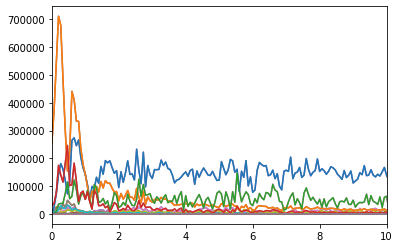

In [3]:
fmax=np.array([extractfmax(eggs[i],2) for i in range(7)]).T
np.save('fmax.npy',fmax)